In [1]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import ipaddress

In [2]:
# Define column names
columns = ['date', 'time', 'trx_id', 'trx_type', 'trx_status', 'category', 'business_type_class', 'wallet_number_from', 'wallet_number_to', 'amount', 'description', 'currency', 'invoice_details', 'ip', 'browser_environment']

# Function to read files from a specified pattern and combine them into a single DataFrame
def read_and_combine_files(file_pattern):
    files = glob.glob(file_pattern)
    dfs = [pd.read_csv(file, names=columns, header=None) for file in files]
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

# Define file patterns for different groups
patterns = {
    'a_to_e': 'segment[a-e]*',
    'f_to_k': 'segment[f-k]*',
    'l_to_z': 'segment[l-z]*'
    # Add more groups as needed
}

# Initialize an empty list to store all combined DataFrames
all_dfs = []

# Iterate over each pattern, read and combine files, then append the result to the list
for pattern in patterns.values():
    combined_df = read_and_combine_files(pattern)
    all_dfs.append(combined_df)

# Concatenate all combined DataFrames into a single DataFrame
final_df = pd.concat(all_dfs, ignore_index=True)

# Now final_df contains all the data from the files across the specified groups


In [3]:
final_df.shape

(16636702, 15)

In [4]:
final_df.head(5)

,date,time,trx_id,trx_type,trx_status,category,business_type_class,wallet_number_from,wallet_number_to,amount,description,currency,invoice_details,ip,browser_environment
0,2021-09-24,23:12:09,6b16fd70-da27-48e9-8506-4467d8e418e8,client_transaction_issue,processed,Home,ClientTransactionProcess,NaN,29598,10000.0,Wooden Fish,EUR,Christian Page,66.99.106.232,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...
1,2023-01-12,16:36:28,d51996eb-d766-4971-9839-7b9902c4e6f8,client_transaction_issue,processed,Kids,ClientTransactionProcess,NaN,64411,10000.0,Small Frozen Pizza,EUR,Joseph Arnold,147.193.110.4,Mozilla/5.0 (Windows NT 10.0; rv:109.0) Gecko/...
2,2019-07-04,17:56:32,70b0a17b-24ce-4e16-850d-ba4520e26538,client_transaction_issue,processed,Music,ClientTransactionProcess,NaN,203804,10000.0,Chicken,EUR,Bryan Alvarez,180.38.191.114,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...
3,2020-03-04,05:32:57,97eaf279-355c-4adc-bc96-a8862184fcfa,client_transaction_issue,processed,Music,ClientTransactionProcess,NaN,281050,10000.0,Practical Concrete Gloves,EUR,Eugene Bell,184.219.186.196,Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Geck...
4,2019-02-26,02:14:23,9a73ca1c-3313-4208-a644-8d5e9336dc5a,client_transaction_issue,processed,Clothing,ClientTransactionProcess,NaN,434373,10000.0,Cotton Cheese,EUR,Ryan Briggs,96.241.27.38,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...


### Checking different values of business_type_class that the dataframe holds

In [5]:
# Get unique values of 'business_type_class'
unique_business_type_classes = final_df['trx_type'].unique()

In [6]:
print(unique_business_type_classes)

['client_transaction_issue' 'client_transaction_transfer'
 'merchant_invoice']


In [7]:
# Dictionary to hold the unique values of each column
unique_values_per_column = {}

# Iterate over each column in the DataFrame
for column in final_df.columns:
    # Get unique values of the column
    unique_values = final_df[column].unique()
    # Add the unique values to the dictionary
    unique_values_per_column[column] = unique_values

# At this point, unique_values_per_column contains the unique values for each column


### Do we have any NULL values ?

In [8]:
# Check for null values and count them
null_counts = final_df.isnull().sum()

# Display the count of null values for each column
print("Null Values Count:")
print(null_counts)

Null Values Count:
date                         0
time                         0
trx_id                       0
trx_type                     0
trx_status                   0
category                     0
business_type_class          0
wallet_number_from     1107909
wallet_number_to             0
amount                       0
description                  0
currency                     0
invoice_details              0
ip                           0
browser_environment          0
dtype: int64


Seems like wallet_number_from has a considerable amount of null values

In [9]:
# Filter for transactions where 'wallet_number_from' is NaN
filtered_df = final_df[final_df['wallet_number_from'].isna()]

In [10]:
# Get rows with unique combinations of 'amount' and 'business_type_class'
distinct_values_df = filtered_df[['amount', 'business_type_class']].drop_duplicates()

In [11]:
distinct_values_df

,amount,business_type_class
0,10000.00,ClientTransactionProcess
16628709,2.30,MerchantInvoiceProcess
16628710,8.80,MerchantInvoiceProcess
16628711,8.52,MerchantInvoiceProcess
16628712,4.79,MerchantInvoiceProcess
...,...,...
16633876,9.36,MerchantInvoiceProcess
16634379,9.11,MerchantInvoiceProcess
16634429,8.72,MerchantInvoiceProcess
16635278,3.81,MerchantInvoiceProcess


In [12]:
selected_df = filtered_df[filtered_df['amount'] != 10000]

In [13]:
selected_df.head(10) #these are for those entries whose amount is not 10000 but have missing from wallet

,date,time,trx_id,trx_type,trx_status,category,business_type_class,wallet_number_from,wallet_number_to,amount,description,currency,invoice_details,ip,browser_environment
16628709,2020-07-01,13:02:41,018dbecf-d64e-710c-ae0b-9b1f3f050e27,merchant_invoice,pending,Movies,MerchantInvoiceProcess,NaN,188907103843,2.30,Metal Salad,EUR,Julie Perkins,69.196.147.61,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; ...
16628710,2019-05-02,03:26:34,018dbed0-17a2-734b-9216-c134e30b0bd0,merchant_invoice,pending,Home,MerchantInvoiceProcess,NaN,770944808835,8.80,Awesome Ball,EUR,Felicia Stevens,100.151.164.165,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
16628711,2023-10-31,15:02:42,018dbecf-da03-7585-ad4a-5997ed1b4f56,merchant_invoice,pending,Clothing,MerchantInvoiceProcess,NaN,889158598442,8.52,Unbranded Granite Computer,EUR,Benjamin Rocha,61.120.24.61,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
16628712,2019-09-13,14:45:30,018dbecf-ca3d-7aef-9f32-30d8374c61f0,merchant_invoice,pending,Computers,MerchantInvoiceProcess,NaN,712163369818,4.79,Used Granite Salad,EUR,Latoya Rogers,34.111.198.174,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...
16628713,2020-12-09,01:25:40,018dbecf-647e-7f2c-9c5c-d65f09dc1647,merchant_invoice,pending,Garden,MerchantInvoiceProcess,NaN,337399871471,3.00,Computer,EUR,Russell Thompson,17.215.24.48,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:10...
16628714,2021-05-15,00:00:14,018dbecf-fbe1-7eaf-a2c1-98afdb36eb84,merchant_invoice,pending,Health,MerchantInvoiceProcess,NaN,432042261798,8.78,Car,EUR,Ronald Erickson,140.137.176.80,Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Geck...
16628715,2022-06-05,00:44:28,018dbecf-c501-7c2f-8baa-583463f1c9d9,merchant_invoice,pending,Kids,MerchantInvoiceProcess,NaN,614711941519,9.30,Wooden Chair,EUR,Nicole Smith,153.119.139.5,Mozilla/5.0 (Windows NT 10.0; rv:109.0) Gecko/...
16628716,2024-01-13,06:25:55,018dbecf-9e4d-77c1-85da-eae5637b3196,merchant_invoice,pending,Garden,MerchantInvoiceProcess,NaN,815685657030,2.73,Frozen Ball,EUR,Benjamin Harris,47.89.95.230,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
16628717,2020-05-16,20:52:22,018dbed0-02d4-77ea-91db-b4bbdffa6566,merchant_invoice,pending,Home,MerchantInvoiceProcess,NaN,988964159098,1.67,Fantastic Rubber Fish,EUR,Haley Taylor,138.168.146.230,Mozilla/5.0 (Windows NT 10.0; rv:109.0) Gecko/...
16628718,2019-08-05,15:42:54,018dbed0-364d-7d83-afff-ff8c311bb174,merchant_invoice,pending,Jewelery,MerchantInvoiceProcess,NaN,98487971350,5.25,For repair Pizza,EUR,William Walker,16.41.92.194,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...


### Considering doing a few sanity checks

In [14]:
## Checking for duplicates on whole records 

# Check for duplicate records in final_df
duplicate_rows = final_df.duplicated()

# Show the duplicate rows
duplicates_df = final_df[duplicate_rows]

In [15]:
duplicates_df # No duplicates

,date,time,trx_id,trx_type,trx_status,category,business_type_class,wallet_number_from,wallet_number_to,amount,description,currency,invoice_details,ip,browser_environment


In [16]:
# Checking for duplicates column wise

In [17]:
# Check for duplicates in the 'transaction_ID' column
is_duplicate = final_df['trx_id'].duplicated()

# To see if there are any duplicates at all
any_duplicates = is_duplicate.any()

# If you also want to display the duplicate transaction_IDs
duplicate_transaction_ids = final_df['trx_id'][is_duplicate]

print("Are there any duplicate transaction IDs?", any_duplicates)
print("Duplicate transaction IDs:", duplicate_transaction_ids.unique())

Are there any duplicate transaction IDs? False
Duplicate transaction IDs: []


In [18]:
# Dictionary to store whether any duplicates exist for each column
duplicates_summary = {}

# Iterate over each column in the DataFrame
for column in final_df.columns:
    # Check for duplicates in the current column
    is_duplicate = final_df[column].duplicated()
    
    # Check if there are any duplicates in this column
    any_duplicates = is_duplicate.any()
    
    # If there are duplicates, retrieve the unique values of duplicates
    if any_duplicates:
        duplicate_values = final_df[column][is_duplicate].unique()
    else:
        duplicate_values = []

    # Store the results in the dictionary
    duplicates_summary[column] = {
        'Has Duplicates': any_duplicates,
        'Unique Duplicate Values': duplicate_values
    }

# Print the summary of duplicates for each column
for col, data in duplicates_summary.items():
    print(f"Column: {col}")
    print(f"  Has Duplicates: {data['Has Duplicates']}")
    if data['Has Duplicates']:
        print(f"  Unique Duplicate Values: {data['Unique Duplicate Values']}")
    print("\n")

Column: date
  Has Duplicates: True
  Unique Duplicate Values: ['2021-03-04' '2020-06-15' '2022-08-18' ... '2019-09-01' '2023-09-14'
 '2023-12-23']


Column: time
  Has Duplicates: True
  Unique Duplicate Values: ['23:50:10' '06:57:11' '19:40:12' ... '20:11:39' '10:29:40' '17:18:42']


Column: trx_id
  Has Duplicates: False


Column: trx_type
  Has Duplicates: True
  Unique Duplicate Values: ['client_transaction_issue' 'client_transaction_transfer'
 'merchant_invoice']


Column: trx_status
  Has Duplicates: True
  Unique Duplicate Values: ['processed' 'pending']


Column: category
  Has Duplicates: True
  Unique Duplicate Values: ['Music' 'Kids' 'Outdoors' 'Health' 'Home' 'Sports' 'Tools' 'Automotive'
 'Jewelery' 'Baby' 'Grocery' 'Industrial' 'Electronics' 'Garden' 'Beauty'
 'Movies' 'Games' 'Clothing' 'Shoes' 'Books' 'Computers' 'Toys']


Column: business_type_class
  Has Duplicates: True
  Unique Duplicate Values: ['ClientTransactionProcess' 'MerchantInvoiceProcess']


Column: wallet

#### Relationship between trx_type and trans_status

In [19]:
# Select the two columns and drop duplicates to get unique combinations
unique_combinations_df = final_df[['trx_type', 'trx_status']].drop_duplicates()

# Display the unique combinations
print(unique_combinations_df)

                             trx_type trx_status
0            client_transaction_issue  processed
18        client_transaction_transfer  processed
16628709             merchant_invoice    pending
16628782             merchant_invoice  processed


#### Relationship between categories and Item_description

In [20]:
# Select the two columns and drop duplicates to get unique combinations
unique_combinations_df = final_df[['category', 'description']].drop_duplicates()

# Display the unique combinations
print(unique_combinations_df)

         category                description
0            Home                Wooden Fish
1            Kids         Small Frozen Pizza
2           Music                    Chicken
3           Music  Practical Concrete Gloves
4        Clothing              Cotton Cheese
...           ...                        ...
4839294     Books          Sleek Wooden Fish
5005819    Sports  Incredible Plastic Cheese
5031815   Grocery     Handcrafted Rubber Hat
5583246    Health     Unbranded Rubber Chair
5985014     Tools          Sleek Wooden Ball

[139392 rows x 2 columns]


In [21]:
## Obviously since both the columns were synthetically generated this wont help us in any way hence the mismatch

#### Relationship between from and to wallet both shouldnt be the same

In [22]:
# Filter the DataFrame to find rows where 'wallet_number_from' equals 'wallet_number_to'
equal_entries_df = final_df[final_df['wallet_number_from'] == final_df['wallet_number_to']]

# Check if there are any such entries
has_equal_entries = not equal_entries_df.empty

# Print the result
print("Are there any entries where 'wallet_number_from' and 'wallet_number_to' are equal?", has_equal_entries)

# Optionally, show the rows where this condition is met
if has_equal_entries:
    print("Rows with equal 'wallet_number_from' and 'wallet_number_to':")
    print(equal_entries_df)

Are there any entries where 'wallet_number_from' and 'wallet_number_to' are equal? True
Rows with equal 'wallet_number_from' and 'wallet_number_to':
               date      time                                trx_id  \
6944155  2020-05-08  22:52:19  56397f92-e3fb-42d3-9f5e-43a37645c02e   
6948186  2019-08-01  15:10:30  3ac89b86-eef7-42a1-b6c0-9c59336657eb   
6956441  2023-03-12  21:35:23  74cda107-80da-4448-a62d-873c1aa96139   
6962449  2019-03-01  02:13:02  ff21e379-4ee9-485f-bff5-87e4f044d98c   
6974653  2022-06-25  08:37:49  1bba7e6b-8bd0-4865-a8b7-ad3eb059e401   
7034739  2019-05-02  04:36:02  d9f4b0c3-72c1-4ba6-a5a6-f544b25be489   
7038743  2022-06-09  08:17:30  ce5ffc42-ae89-449f-95fa-ced0d8b16d91   
7074269  2020-06-11  01:27:12  260d9052-4433-41cb-a2af-6542e6253249   
7107002  2022-02-28  20:43:02  8dd2fa9c-e189-4973-9edc-dfd159faaf06   
7128041  2023-11-17  20:31:30  95e20382-b28b-45cb-a66d-4c979ce41c5a   
7138209  2022-01-03  21:36:19  7a801869-d72e-4bca-acb8-92376e78c990   

#### Relationship between business_type_class and trx_type

In [23]:
# Select the two columns and drop duplicates to get unique combinations
unique_combinations_df = final_df[['trx_type', 'business_type_class']].drop_duplicates()

# Display the unique combinations
print(unique_combinations_df)

                             trx_type       business_type_class
0            client_transaction_issue  ClientTransactionProcess
18        client_transaction_transfer  ClientTransactionProcess
16628709             merchant_invoice    MerchantInvoiceProcess


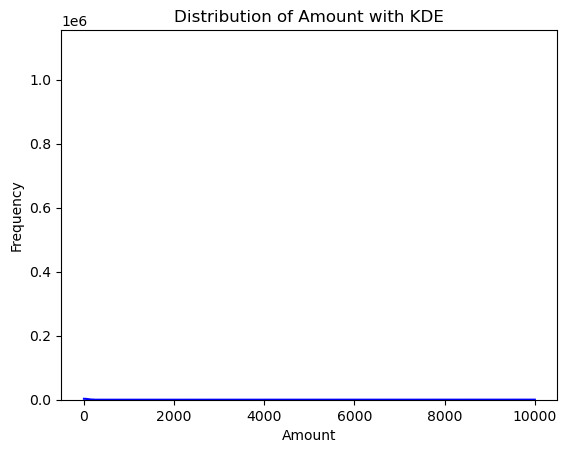

In [24]:
# Assuming 'final_df' is your DataFrame and 'amt' is the column of interest
# Plotting the histogram with a KDE line
sns.histplot(final_df['amount'], kde=True, color='blue')

# Adding titles and labels
plt.title('Distribution of Amount with KDE')
plt.xlabel('Amount')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [25]:
# Define the bins
bins = range(1, 12000, 1000)  # Goes up to 10,000 with steps of 1000

# Use pd.cut to bin the data
final_df['amount_bin'] = pd.cut(final_df['amount'], bins=bins, right=False, include_lowest=True)

# Count the number of entries in each bin
amount_bin_counts = final_df['amount_bin'].value_counts().sort_index()

# Display the counts for each bin
print(amount_bin_counts)

[1, 1001)         15536683
[1001, 2001)             0
[2001, 3001)             0
[3001, 4001)             0
[4001, 5001)             0
[5001, 6001)             0
[6001, 7001)             0
[7001, 8001)             0
[8001, 9001)             0
[9001, 10001)      1100000
[10001, 11001)           0
Name: amount_bin, dtype: int64


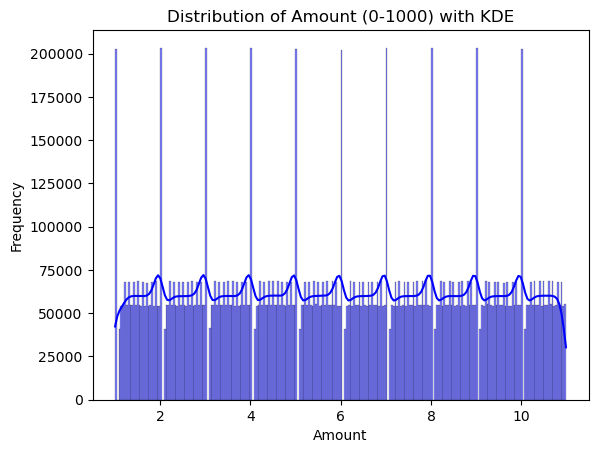

In [26]:
# Filter the DataFrame to include only amounts between 0 and 1000
filtered_data = final_df[(final_df['amount'] >= 1) & (final_df['amount'] <= 1000)]

# Plotting the histogram with a KDE line
sns.histplot(filtered_data['amount'], kde=True, color='blue')

# Adding titles and labels
plt.title('Distribution of Amount (0-1000) with KDE')
plt.xlabel('Amount')
plt.ylabel('Frequency')

# Show the plot
plt.show()

##### Quite a lot of entries with amount as 10,000 -- need to have a look

In [27]:
# Filter the DataFrame to find rows where 'amount' equals 10,000
amount_10000_df = final_df[final_df['amount'] == 10000]

amount_10000_df

# Select the two columns and drop duplicates to get unique combinations
unique_combinations_df = amount_10000_df[['trx_type', 'business_type_class']].drop_duplicates()

# Display the unique combinations
print(unique_combinations_df)

                   trx_type       business_type_class
0  client_transaction_issue  ClientTransactionProcess


In [28]:
# Filter the DataFrame for rows where 'trx_type' equals 'client_transaction_issue'
filtered_df = final_df[final_df['trx_type'] == 'client_transaction_issue']

# Get unique amounts from these filtered entries
unique_amounts = filtered_df['amount'].unique()

# Display the unique amounts
print(unique_amounts)

[10000.     0.]


So all entries of client_transaction_issue are with amount =10,000, this doesn't help us much

#### invoice_details name should match with wallet_number_from

In [29]:
# First, filter out rows where 'wallet_number_from' is NA
filtered_df = final_df.dropna(subset=['wallet_number_from'])

# Group by 'invoice_details' and check unique 'wallet_number_from' for each group
relationship_check = filtered_df.groupby('invoice_details')['wallet_number_from'].nunique()

# Filter to find only those invoice details with more than one unique wallet_number_from
multiple_wallets = relationship_check[relationship_check > 1]

# Display the invoice details with their counts of unique wallet_number_from
print("Invoice details with multiple unique wallet_number_from:")
print(multiple_wallets)

Invoice details with multiple unique wallet_number_from:
invoice_details
Aaron Abbott        23
Aaron Abbott MD      2
Aaron Acevedo       13
Aaron Acosta        31
Aaron Adams        164
                  ... 
Zoe Yoder            2
Zoe Young           15
Zoe Zavala           2
Zoe Zimmerman        2
Zoe Zuniga           3
Name: wallet_number_from, Length: 653113, dtype: int64


In [30]:
# Filter the DataFrame to find rows where 'invoice_details' equals 'Aaron Abbott'
selected_df = filtered_df[filtered_df['invoice_details'] == 'Zoe Welch']

selected_df

,date,time,trx_id,trx_type,trx_status,category,business_type_class,wallet_number_from,wallet_number_to,amount,description,currency,invoice_details,ip,browser_environment,amount_bin
1556588,2023-06-28,12:28:00,018db957-1c33-79bc-a664-6caffcd532d5,client_transaction_transfer,processed,Computers,ClientTransactionProcess,10282.0,221373,3.68,Salad,EUR,Zoe Welch,66.54.107.241,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"[1, 1001)"
1931216,2023-02-25,01:28:46,018db993-43de-7ed5-b5eb-80c45d805d94,client_transaction_transfer,processed,Electronics,ClientTransactionProcess,40315.0,759078,5.56,Cheese,EUR,Zoe Welch,44.70.133.143,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"[1, 1001)"
10204437,2022-11-29,19:09:34,018dba84-9034-7f46-b890-d0b55e6f0043,client_transaction_transfer,processed,Games,ClientTransactionProcess,164671.0,211994,7.61,Plastic Gloves,EUR,Zoe Welch,100.243.237.125,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"[1, 1001)"
10394054,2021-02-11,08:39:18,018db9c6-f7f0-7c92-81a0-2f70499627d6,client_transaction_transfer,processed,Home,ClientTransactionProcess,66707.0,693341,8.32,Ball,EUR,Zoe Welch,188.143.70.123,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"[1, 1001)"
10718759,2019-03-11,20:13:08,018dbaea-2f67-7c3b-a717-06ee76aae06b,client_transaction_transfer,processed,Beauty,ClientTransactionProcess,218147.0,607133,7.43,Granite Chicken,EUR,Zoe Welch,200.120.59.23,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,"[1, 1001)"


In [31]:
## adding browser_environment in group as well

In [32]:
# First, filter out rows where 'wallet_number_from' is NA
filtered_df = final_df.dropna(subset=['wallet_number_from'])

# Group by 'invoice_details' and 'browser_environment' and check unique 'wallet_number_from' for each group
relationship_check = filtered_df.groupby(['invoice_details', 'browser_environment'])['wallet_number_from'].nunique()

# Filter to find only those groupings with more than one unique wallet_number_from
multiple_wallets = relationship_check[relationship_check > 1]

# Display the groupings with their counts of unique wallet_number_from
print("Groupings with multiple unique wallet_number_from:")
print(multiple_wallets)

Groupings with multiple unique wallet_number_from:
invoice_details  browser_environment                                                                                                              
Aaron Abbott     Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.4 Safari/605.1.15                2
                 Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.5 Safari/605.1.15                2
                 Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36 Edg/117.0.2045.36    2
                 Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36 Edg/117.0.2045.43    2
                 Mozilla/5.0 (Windows NT 10.0; rv:109.0) Gecko/20100101 Firefox/117.0                                                                 2
                                          

In [33]:
# Filter the DataFrame to find rows where 'invoice_details' equals 'Zoe Welch' 
# and 'browser_environment' equals the specified Mozilla Firefox user agent
selected_df = filtered_df[
    (filtered_df['invoice_details'] == 'Aaron Adams') & 
    (filtered_df['browser_environment'] == 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:109.0) Gecko/20100101 Firefox/116.0')
]

# Display these rows
selected_df

,date,time,trx_id,trx_type,trx_status,category,business_type_class,wallet_number_from,wallet_number_to,amount,description,currency,invoice_details,ip,browser_environment,amount_bin
347854,2021-09-20,15:42:12,018dbaca-d3ef-723e-a729-c382b750b324,client_transaction_transfer,processed,Baby,ClientTransactionProcess,201808.0,894038,1.73,Unbranded Soap,EUR,Aaron Adams,158.14.116.62,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; ...,"[1, 1001)"
1071381,2023-10-19,22:51:17,018dbaef-1891-72a2-939c-6490f74303fa,client_transaction_transfer,processed,Tools,ClientTransactionProcess,220710.0,67001,1.89,Soap,EUR,Aaron Adams,32.193.216.123,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; ...,"[1, 1001)"
4955178,2021-07-04,07:20:58,018db9cb-64ff-7bb2-8e4b-e1c1084ba889,client_transaction_transfer,processed,Health,ClientTransactionProcess,68943.0,568499,7.18,Awesome Concrete Hat,EUR,Aaron Adams,97.84.49.182,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; ...,"[1, 1001)"
6697122,2020-02-16,21:54:55,018db7ad-a2ef-7c3a-a76f-907758357c46,client_transaction_transfer,processed,Clothing,ClientTransactionProcess,932249.0,421393,4.00,Ergonomic Cotton Tuna,EUR,Aaron Adams,33.2.83.1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; ...,"[1, 1001)"
14124688,2020-11-25,11:36:37,018dbb21-9898-7b26-92ca-24bf21acdd4f,client_transaction_transfer,processed,Beauty,ClientTransactionProcess,246881.0,931301,3.93,Licensed Cheese,EUR,Aaron Adams,39.150.246.179,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; ...,"[1, 1001)"


#### Checking range of date

In [34]:
# Assuming 'date' is in a suitable date format, if not, you will need to convert it first
# Convert 'date' to datetime format if necessary
final_df['date'] = pd.to_datetime(final_df['date'], errors='coerce')

# Find the minimum and maximum date
min_date = final_df['date'].min()
max_date = final_df['date'].max()

# Display the date range
print("Date range: from", min_date, "to", max_date)

Date range: from 2019-02-20 00:00:00 to 2024-02-20 00:00:00


5 years of data

### Data Visualisation

#### Heatmaps across day of the week and hours of the day

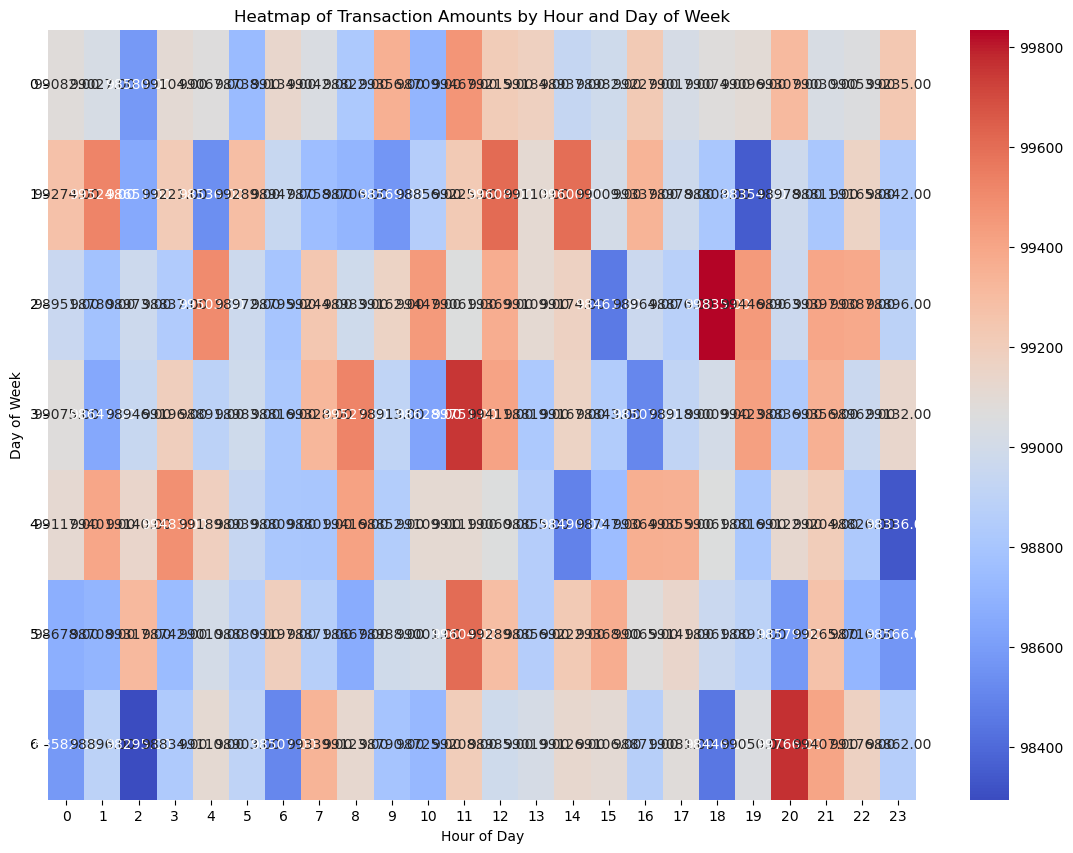

In [35]:
# First, ensure that 'date' is a date and 'time' is a time type or string
# Here we assume 'date' is already datetime type and 'time' is a string representing time
final_df['datetime'] = pd.to_datetime(final_df['date'].astype(str) + ' ' + final_df['time'])

# After creating the 'datetime' column, proceed to extract 'hour' and 'day_of_week'
final_df['hour'] = final_df['datetime'].dt.hour
final_df['day_of_week'] = final_df['datetime'].dt.dayofweek

# Now you can create the pivot table and plot
pivot_table = final_df.pivot_table(index='day_of_week', columns='hour', values='amount', aggfunc='count', fill_value=0)


plt.figure(figsize=(14, 10))
ax = sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 10, 'rotation': 'horizontal'})
plt.title('Heatmap of Transaction Amounts by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

##### proportions of processed vs. pending transactions within each type.

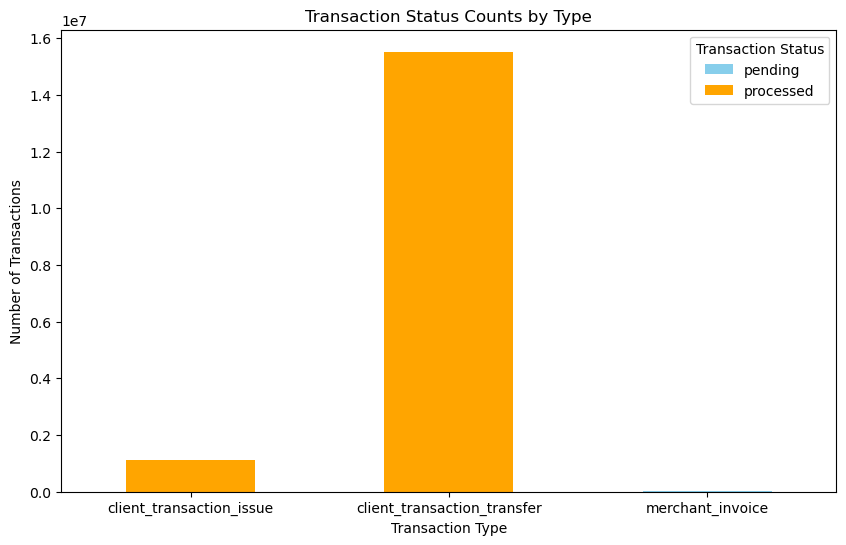

In [36]:
status_counts = final_df.pivot_table(index='trx_type', columns='trx_status', values='trx_id', aggfunc='count', fill_value=0)

# Plotting the stacked bar chart
status_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange'])
plt.title('Transaction Status Counts by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)  # Keep the labels horizontal for better readability
plt.legend(title='Transaction Status')
plt.show()

##### Top selling Wallets 

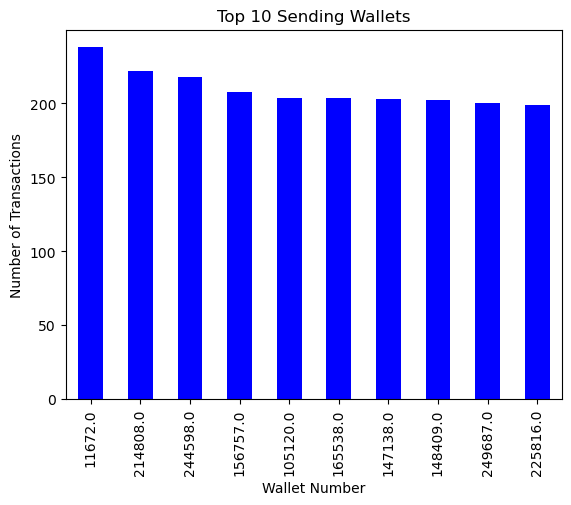

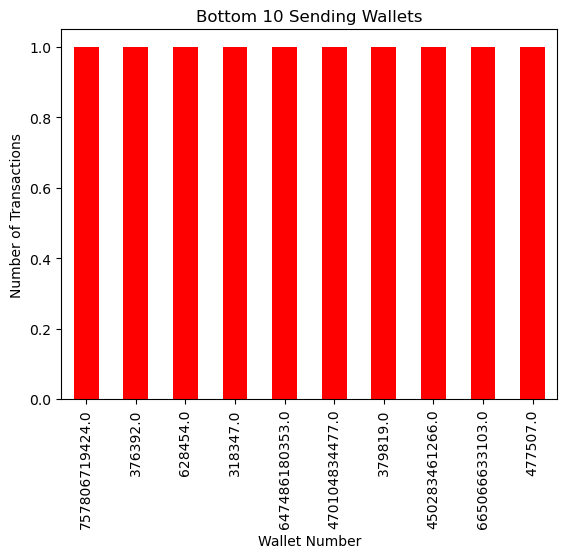

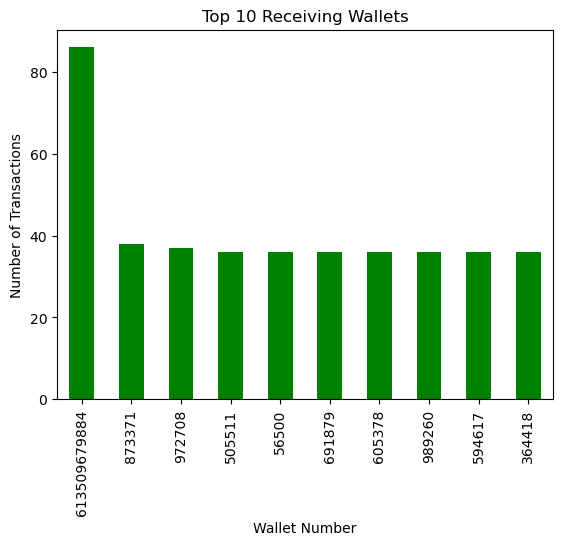

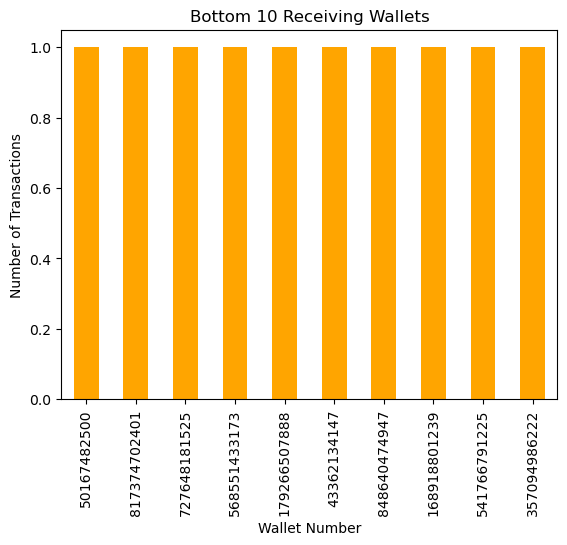

In [37]:
# Assuming final_df is your DataFrame

# Count transactions for each wallet in 'wallet_number_from'
from_counts = final_df['wallet_number_from'].value_counts()

# Get the top 10 and bottom 10 wallets in 'wallet_number_from'
top_10_from = from_counts.head(10)
bottom_10_from = from_counts.tail(10)

# Count transactions for each wallet in 'wallet_number_to'
to_counts = final_df['wallet_number_to'].value_counts()

# Get the top 10 and bottom 10 wallets in 'wallet_number_to'
top_10_to = to_counts.head(10)
bottom_10_to = to_counts.tail(10)

# Plotting top 10 'wallet_number_from'
top_10_from.plot(kind='bar', title='Top 10 Sending Wallets', color='blue')
plt.xlabel('Wallet Number')
plt.ylabel('Number of Transactions')
plt.show()

# Plotting bottom 10 'wallet_number_from'
bottom_10_from.plot(kind='bar', title='Bottom 10 Sending Wallets', color='red')
plt.xlabel('Wallet Number')
plt.ylabel('Number of Transactions')
plt.show()

# Plotting top 10 'wallet_number_to'
top_10_to.plot(kind='bar', title='Top 10 Receiving Wallets', color='green')
plt.xlabel('Wallet Number')
plt.ylabel('Number of Transactions')
plt.show()

# Plotting bottom 10 'wallet_number_to'
bottom_10_to.plot(kind='bar', title='Bottom 10 Receiving Wallets', color='orange')
plt.xlabel('Wallet Number')
plt.ylabel('Number of Transactions')
plt.show()

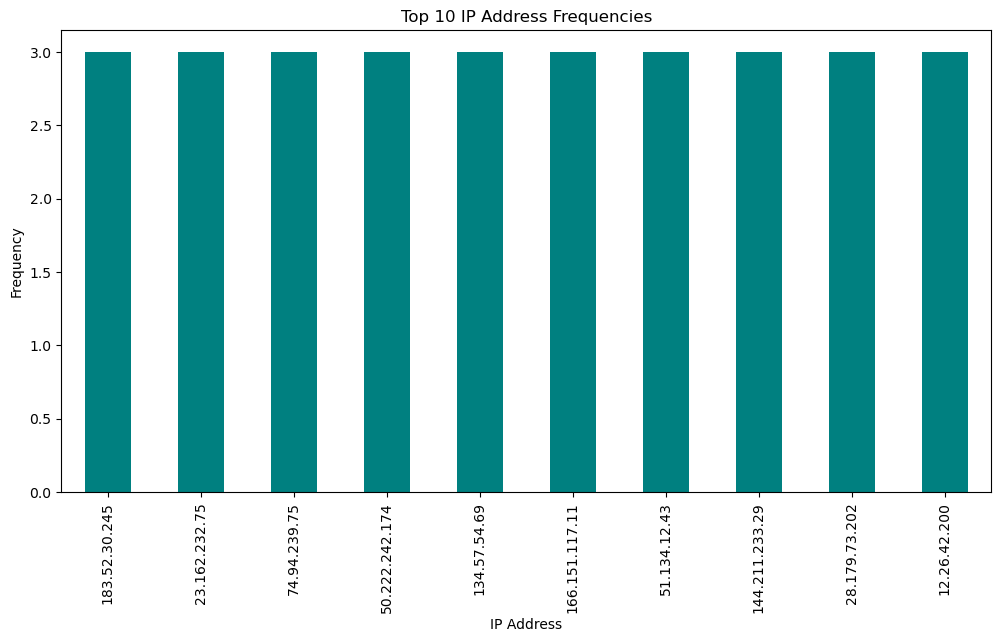

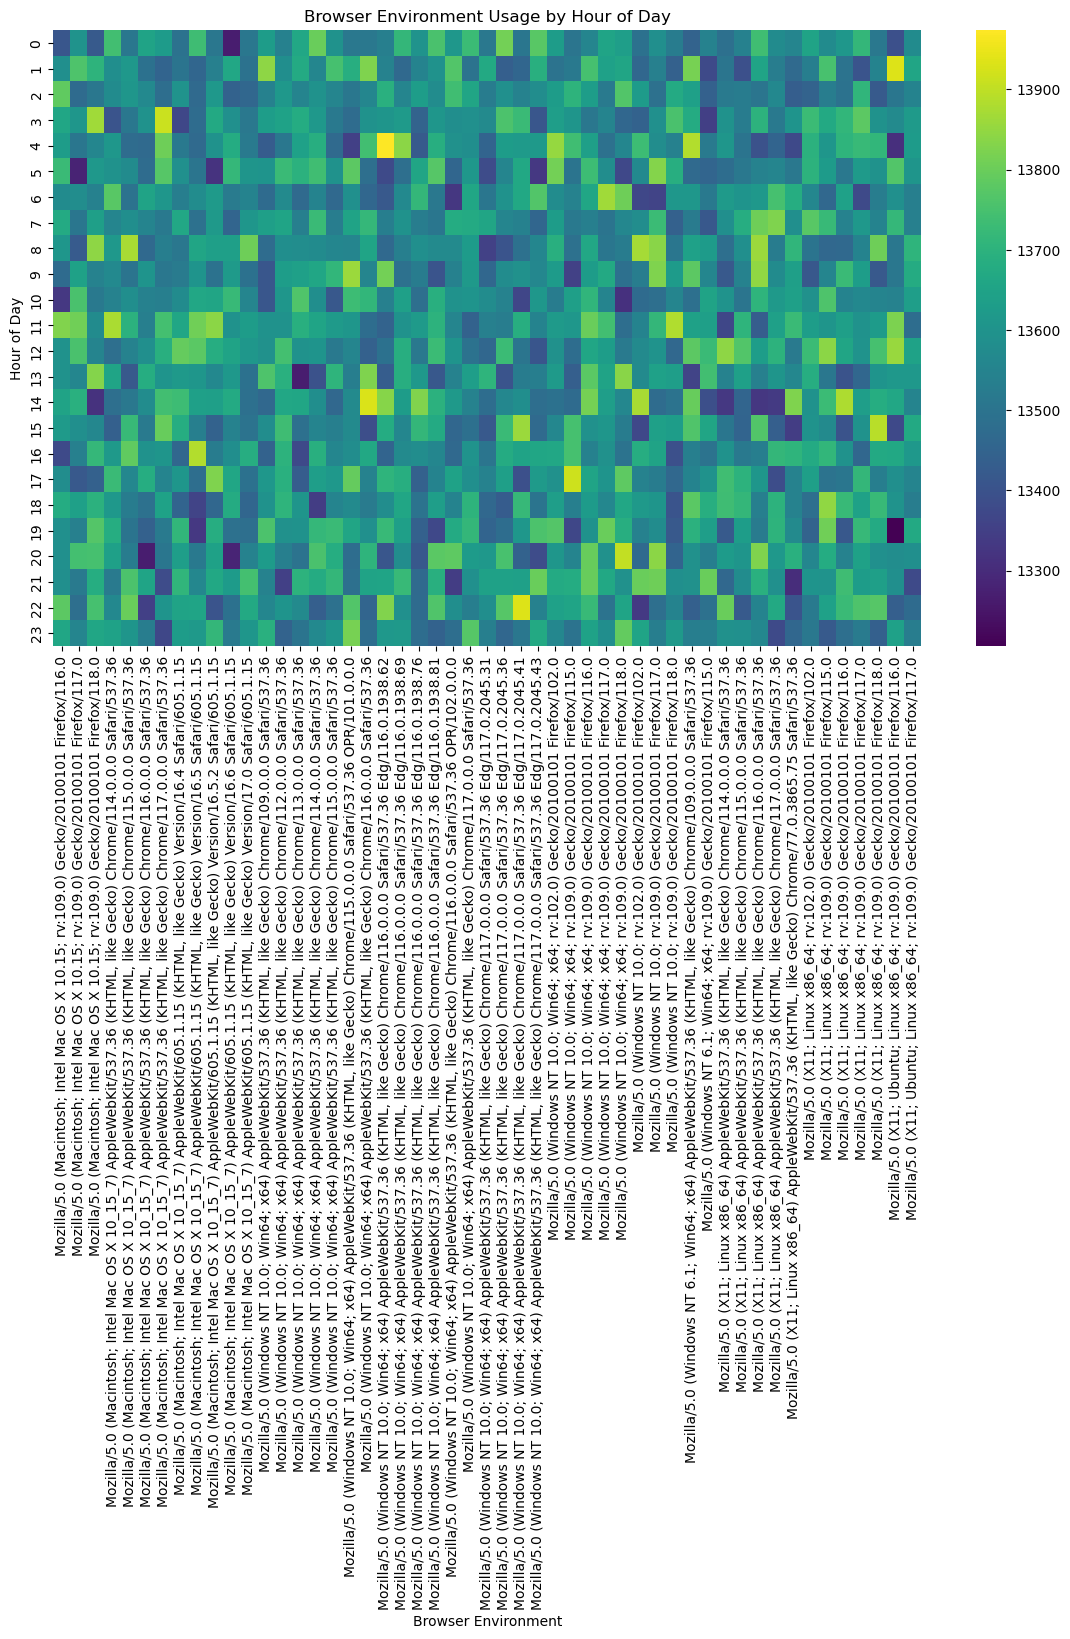

In [38]:
# Assuming 'final_df' is your DataFrame

# Count the occurrences of each IP and sort them in descending order explicitly
ip_counts = final_df['ip'].value_counts().sort_values(ascending=False)

# Plotting the bar chart for IP counts
plt.figure(figsize=(12, 6))
ip_counts.head(10).plot(kind='bar', color='teal')  # Top 10 IPs
plt.title('Top 10 IP Address Frequencies')
plt.xlabel('IP Address')
plt.ylabel('Frequency')
plt.show()

# Creating a crosstab for browser environment occurrences by hour
final_df['hour'] = final_df['datetime'].dt.hour  # Assuming datetime is already a datetime column
browser_heatmap_data = pd.crosstab(final_df['hour'], final_df['browser_environment'])

# Plotting the heatmap for browser environment by hour
plt.figure(figsize=(14, 8))
sns.heatmap(browser_heatmap_data, annot=False, cmap='viridis')
plt.title('Browser Environment Usage by Hour of Day')
plt.xlabel('Browser Environment')
plt.ylabel('Hour of Day')
plt.show()


#### Frequency of change in wallet_to

In [39]:
# Assuming a change in wallet_number_to might indicate an address change,
# count these changes per 'wallet_number_from'
change_frequency = final_df.groupby('wallet_number_from')['wallet_number_to'].nunique()

# Add this change frequency data back to the main DataFrame
final_df['Wallet_to_change_frequency'] = final_df['wallet_number_from'].map(change_frequency)


#### Frequency of change in IP

In [40]:
# Count unique IPs used by each wallet_number_from
ip_change_frequency = final_df.groupby('wallet_number_from')['ip'].nunique()

# Add this IP change frequency data back to the main DataFrame
final_df['IP Change Frequency'] = final_df['wallet_number_from'].map(ip_change_frequency)

# Display data to inspect potential IP change frequency
print(final_df[['wallet_number_from', 'IP Change Frequency']].head())

   wallet_number_from  IP Change Frequency
0                 NaN                  NaN
1                 NaN                  NaN
2                 NaN                  NaN
3                 NaN                  NaN
4                 NaN                  NaN


#### Log transformed age of the customer (Retention Rate)

In [41]:
# Assuming 'final_df' has a 'datetime' column which is already in datetime format
# Calculate the earliest transaction date per wallet
min_dates = final_df.groupby('wallet_number_from')['datetime'].min().reset_index(name='First Transaction Date')

# Calculate the number of transactions per wallet
transaction_counts = final_df.groupby('wallet_number_from').size().reset_index(name='Transaction Count')

# Merge these metrics back to the main DataFrame
# Ensure the merge is performed correctly by specifying 'wallet_number_from' explicitly
account_metrics = pd.merge(min_dates, transaction_counts, on='wallet_number_from')
final_df = pd.merge(final_df, account_metrics, on='wallet_number_from', how='left')

# Calculate "Transaction Frequency" as days active divided by number of transactions
final_df['Days Since First Transaction'] = (pd.Timestamp('now') - final_df['First Transaction Date']).dt.days
final_df['Transaction Frequency'] = final_df['Days Since First Transaction'] / final_df['Transaction Count']

# Adjusted "Account Age" using logarithmic scale to normalize the distribution
final_df['Adjusted Account Age'] = np.log(final_df['Days Since First Transaction'] + 1) / (final_df['Transaction Frequency'] + 1)

final_df

,date,time,trx_id,trx_type,trx_status,category,business_type_class,wallet_number_from,wallet_number_to,amount,...,datetime,hour,day_of_week,Wallet_to_change_frequency,IP Change Frequency,First Transaction Date,Transaction Count,Days Since First Transaction,Transaction Frequency,Adjusted Account Age
0,2021-09-24,23:12:09,6b16fd70-da27-48e9-8506-4467d8e418e8,client_transaction_issue,processed,Home,ClientTransactionProcess,NaN,29598,10000.00,...,2021-09-24 23:12:09,23,4,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,2023-01-12,16:36:28,d51996eb-d766-4971-9839-7b9902c4e6f8,client_transaction_issue,processed,Kids,ClientTransactionProcess,NaN,64411,10000.00,...,2023-01-12 16:36:28,16,3,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,2019-07-04,17:56:32,70b0a17b-24ce-4e16-850d-ba4520e26538,client_transaction_issue,processed,Music,ClientTransactionProcess,NaN,203804,10000.00,...,2019-07-04 17:56:32,17,3,NaN,NaN,NaT,NaN,NaN,NaN,NaN
3,2020-03-04,05:32:57,97eaf279-355c-4adc-bc96-a8862184fcfa,client_transaction_issue,processed,Music,ClientTransactionProcess,NaN,281050,10000.00,...,2020-03-04 05:32:57,5,2,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,2019-02-26,02:14:23,9a73ca1c-3313-4208-a644-8d5e9336dc5a,client_transaction_issue,processed,Clothing,ClientTransactionProcess,NaN,434373,10000.00,...,2019-02-26 02:14:23,2,1,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16636697,2023-07-23,01:46:32,018dbed0-1eec-7fd8-834a-5981a8e33228,merchant_invoice,pending,Jewelery,MerchantInvoiceProcess,NaN,263431068876,9.97,...,2023-07-23 01:46:32,1,6,NaN,NaN,NaT,NaN,NaN,NaN,NaN
16636698,2021-04-07,13:43:48,018dbed0-0bd6-7059-b424-ef77eb7afa86,merchant_invoice,pending,Kids,MerchantInvoiceProcess,NaN,341927208181,9.23,...,2021-04-07 13:43:48,13,2,NaN,NaN,NaT,NaN,NaN,NaN,NaN
16636699,2023-05-12,10:57:41,018dbed0-2be2-7af2-bbff-da057cbee8f0,merchant_invoice,pending,Outdoors,MerchantInvoiceProcess,NaN,356810060796,9.67,...,2023-05-12 10:57:41,10,4,NaN,NaN,NaT,NaN,NaN,NaN,NaN
16636700,2020-01-20,21:01:32,018dbecf-ecfc-738f-a612-b951dcfb0578,merchant_invoice,pending,Garden,MerchantInvoiceProcess,NaN,781809649125,6.60,...,2020-01-20 21:01:32,21,0,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [42]:
final_df.columns

Index(['date', 'time', 'trx_id', 'trx_type', 'trx_status', 'category',
       'business_type_class', 'wallet_number_from', 'wallet_number_to',
       'amount', 'description', 'currency', 'invoice_details', 'ip',
       'browser_environment', 'amount_bin', 'datetime', 'hour', 'day_of_week',
       'Wallet_to_change_frequency', 'IP Change Frequency',
       'First Transaction Date', 'Transaction Count',
       'Days Since First Transaction', 'Transaction Frequency',
       'Adjusted Account Age'],
      dtype='object')

#### Flagging microtransactions

In [43]:
import pandas as pd

# Assuming 'final_df' is your DataFrame and it contains 'date' and 'time' columns
# Ensure that both 'date' and 'time' are strings if not already
final_df['date'] = final_df['date'].astype(str)
final_df['time'] = final_df['time'].astype(str)

# Combine 'date' and 'time' into a single datetime column for easier manipulation
# Format depends on your actual date and time format, here assuming 'YYYY-MM-DD' and 'HH:MM:SS'
final_df['datetime'] = pd.to_datetime(final_df['date'] + ' ' + final_df['time'])

# Function to detect rapid transactions for a specific wallet within a defined time span
def detect_rapid_transactions(group, hours=5, max_amount=6):
    # Convert hours to the equivalent in timedelta
    time_threshold = pd.Timedelta(hours=hours)
    
    # Calculate the time differences within the group
    group = group.sort_values(by='datetime')  # Ensure the group is sorted by datetime
    group['time_diff'] = group['datetime'].diff().fillna(pd.Timedelta(seconds=0))
    
    # Identify transactions where the cumulative sum of time differences is within the threshold
    group['transaction_within_hours'] = group['time_diff'].cumsum() <= time_threshold
    
    # Additionally, filter out transactions where the amount is less than or equal to the max_amount
    group['valid_amount'] = group['amount'] <= max_amount
    
    # Combine the conditions
    group['flagged'] = group['transaction_within_hours'] & group['valid_amount']
    
    return group

# Apply the function to each wallet's transactions
final_df = final_df.groupby('wallet_number_from').apply(detect_rapid_transactions).reset_index(drop=True)

# Filter to find the cases where multiple transactions occur within the time threshold and amount condition
flagged_transactions = final_df[final_df['flagged']]

# Select relevant information to review
review_transactions = flagged_transactions[['wallet_number_from', 'datetime', 'amount', 'ip', 'flagged']]

print(review_transactions)

          wallet_number_from            datetime  amount              ip  \
214             4.000000e+00 2019-06-08 14:03:23    6.00  118.236.52.245   
325             6.000000e+00 2019-02-27 04:40:29    2.25    10.234.43.30   
670             1.100000e+01 2019-02-28 11:17:57    5.45   100.22.59.252   
980             1.500000e+01 2019-03-10 06:18:20    3.35    90.98.23.203   
1057            1.600000e+01 2019-02-21 13:32:50    5.14  114.232.67.146   
...                      ...                 ...     ...             ...   
15528788        7.578067e+11 2022-06-25 08:37:49    0.00    76.89.13.177   
15528789        8.325801e+11 2019-08-01 15:10:30    0.00    85.7.205.128   
15528790        8.430225e+11 2023-11-17 20:31:30    0.00   207.211.58.71   
15528791        8.676245e+11 2019-03-01 02:13:02    0.00  137.110.113.14   
15528792        8.880551e+11 2019-12-02 22:16:11    0.00   58.98.227.143   

          flagged  
214          True  
325          True  
670          True  
980    

#### IP Mapping

In [44]:
# Define column names
column_names = ['start', 'end', 'country_code', 'country', 'region', 'city', 'lat', 'long']

# Read the CSV file with specified column names
ip_map = pd.read_csv('IP2LOCATION-LITE-DB5.csv', names=column_names)

ip_map

,start,end,country_code,country,region,city,lat,long
0,0,16777215,-,-,-,-,0.000000,0.000000
1,16777216,16777471,US,United States of America,California,San Jose,37.339390,-121.894960
2,16777472,16778239,CN,China,Fujian,Fuzhou,26.061390,119.306110
3,16778240,16779263,AU,Australia,Victoria,Melbourne,-37.814007,144.963171
4,16779264,16781311,CN,China,Guangdong,Guangzhou,23.127361,113.264570
...,...,...,...,...,...,...,...,...
2960669,3758094336,3758095359,HK,Hong Kong,Hong Kong,Hong Kong,22.285520,114.157690
2960670,3758095360,3758095871,CN,China,Fujian,Fuzhou,26.061390,119.306110
2960671,3758095872,3758096127,SG,Singapore,Singapore,Singapore,1.289987,103.850281
2960672,3758096128,3758096383,AU,Australia,Queensland,Brisbane,-27.467540,153.028090


In [45]:
# Function to convert IP address to a numerical value
def ip_to_int(ip):
    return int(ipaddress.ip_address(ip))

# Apply the function to the 'ip' column
final_df['ip_number'] = final_df['ip'].apply(ip_to_int)

In [46]:
# Convert IP range start and end to integers
ip_map['start_int'] = ip_map['start'].apply(ip_to_int)
ip_map['end_int'] = ip_map['end'].apply(ip_to_int)

# Create IntervalIndex from these ranges
ip_map['ip_range'] = pd.IntervalIndex.from_arrays(ip_map['start_int'], ip_map['end_int'], closed='both')
ip_map.set_index('ip_range', inplace=True)


In [ ]:
# Function to lookup geographical information based on IP number
def lookup_geo_data(ip_num):
    try:
        # ip_map.loc works with IntervalIndex to find the interval that ip_num falls into
        record = ip_map.loc[ip_num]
        return pd.Series({
            'country': record['country'],
            'city': record['city'],
            'region': record['region'],
            'lat': record['lat'],  # Include latitude
            'long': record['long']  # Include longitude
        })
    except KeyError:
        # Return NaN or some defaults if no match is found
        return pd.Series({
            'country': None,
            'city': None,
            'region': None,
            'lat': None,  # Include latitude
            'long': None  # Include longitude
        })

# Apply this lookup function to the 'ip_number' column
geo_data = final_df['ip_number'].apply(lookup_geo_data)

# Join the geographical data back to the original DataFrame
final_df = final_df.join(geo_data)

In [ ]:
# Remove the specified columns from the DataFrame
final_df = final_df.drop(columns=['time_diff', 'transaction_within_hours', 'valid_amount'])

In [ ]:
# Specify the path where you want to save the CSV file
#file_path = 'C:/Users/jithi/OneDrive/Desktop/Final_Data.csv'

# Save the DataFrame to a CSV file at the specified path
#final_df.to_csv(file_path, index=False)  # Set index=False if you do not want to save the DataFrame index as a column in the file


### IP'S ON MAP

In [ ]:
# Initialize the Dash app
app = dash.Dash(__name__)

# Assuming final_df has all necessary columns properly formatted and ready to use
# Convert 'date' column to datetime if not already
final_df['date'] = pd.to_datetime(final_df['date'], errors='coerce')

# Dash layout
app.layout = html.Div([
    dcc.Dropdown(
        id='wallet-dropdown',
        options=[{'label': wallet, 'value': wallet} for wallet in final_df['wallet_number_from'].unique()],
        value=final_df['wallet_number_from'].unique()[0],  # Set the default value to the first entry
        style={'color': 'black'}  # Dropdown styling
    ),
    dcc.Graph(id='map-graph', style={'height': '800px'})  # Increase the size of the map
])

# Callback to update the map based on the wallet selection
@app.callback(
    Output('map-graph', 'figure'),
    [Input('wallet-dropdown', 'value')]
)
def update_map(selected_wallet):
    # Filter the DataFrame based on the selected wallet
    filtered_df = final_df[final_df['wallet_number_from'] == selected_wallet]
    
    # Convert 'date' to string for display in hover data, ensure it's datetime first
    if pd.api.types.is_datetime64_any_dtype(filtered_df['date']):
        filtered_df['date_str'] = filtered_df['date'].dt.strftime('%Y-%m-%d')
    else:
        filtered_df['date_str'] = 'Not Available'

    # Generate a scatter geo map
    fig = px.scatter_geo(filtered_df,
                         lat='lat',
                         lon='long',
                         text='city',  # Show city names on the markers
                         hover_name='country',  # Main hover information is the country
                         hover_data={'region': True, 'date_str': True},  # Additional hover info: region and transaction date
                         projection='natural earth',
                         title=f'Transactions for Wallet: {selected_wallet}',
                         color_discrete_sequence=['pink'])  # Set markers to pink

    # Update map layout to dark mode with white text
    fig.update_layout(
        geo=dict(
            bgcolor='rgb(10,10,10)',  # Dark background for the globe
            lakecolor='rgb(10,10,10)',  # Dark lakes
            landcolor='rgb(50,50,50)',  # Dark land
            subunitcolor='rgb(100,100,100)'  # Darker borders
        ),
        paper_bgcolor='rgb(10,10,10)',  # Background color around the map
        plot_bgcolor='rgb(10,10,10)',  # Plot background color
        title_font=dict(color='white'),  # Set the title font color to white
        font=dict(color='white')  # Set global font color to white for all text
    )

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

In [ ]:
final_df.head(5)

### Correlation

In [ ]:
# Calculate the correlation matrix
corr = final_df.corr()

# Create a heatmap using seaborn library
plt.figure(figsize=(10, 8))  # Set the figure size for the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, 
            xticklabels=corr.columns, yticklabels=corr.columns)

# Add titles and labels for clarity
plt.title('Correlation Heatmap')
plt.xlabel('Variables')
plt.ylabel('Variables')

# Show the plot
plt.show()